In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import nltk
from nltk.corpus import stopwords
import re

In [9]:
# Tải kho 'stop words' tiếng Bồ Đào Nha 
nltk.download('stopwords')
portuguese_stops = set(stopwords.words('portuguese'))

print(f"Đã tải {len(portuguese_stops)} stop words tiếng Bồ Đào Nha.")

Đã tải 207 stop words tiếng Bồ Đào Nha.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinhq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Tải Dữ liệu 
DB_CONFIG = {
    "dbname": "olist_db",
    "user": "postgres", 
    "password": "YOUR_DB_PASSWORD",
    "host": "localhost",
    "port": 5432,
}

conn_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"
engine = create_engine(conn_string)

# Lấy các bình luận 1-2 sao từ bảng STAGING (nơi chứa văn bản)
df_reviews = pd.read_sql_table('nlp_bad_review', engine, schema='warehouse')
df_reviews = df_reviews.dropna() 

print(f"Đã tải {len(df_reviews)} bình luận 1-2 sao để phân tích.")

Đã tải 14396 bình luận 1-2 sao để phân tích.


In [11]:
# 3. Truy vấn lấy tổng số lượng bản ghi (Total Count)
# Lấy tổng số dòng trong bảng để làm mẫu số
sql_query_total = "SELECT COUNT(*) FROM staging.reviews_cleaned"

print("Đang tải dữ liệu...")

# Thực thi lấy dữ liệu chi tiết
df_reviews = df_reviews.dropna()

# Thực thi lấy tổng số dòng 
total_reviews_count = pd.read_sql(sql_query_total, engine).iloc[0, 0]

# 4. Tính toán phần trăm
target_count = len(df_reviews)
percentage = (target_count / total_reviews_count) * 100

print(f"Tổng số review trong Database: {total_reviews_count:,}")
print(f"Số lượng review tiêu cực (1-2 sao, có lời bình): {target_count:,}")
print(f" -> Chiếm tỷ lệ: {percentage:.2f}% trên tổng số.")

Đang tải dữ liệu...
Tổng số review trong Database: 98,410
Số lượng review tiêu cực (1-2 sao, có lời bình): 14,396
 -> Chiếm tỷ lệ: 14.63% trên tổng số.


In [12]:
# Hàm Tiền xử lý Văn bản
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Chuyển sang chữ thường
    text = text.lower()
    
    # Xóa các ký tự đặc biệt, số (chỉ giữ lại chữ cái)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    # Tách từ (Tokenization) và Xóa Stop Words
    cleaned_words = []
    for word in text.split():
        if word not in portuguese_stops:
            cleaned_words.append(word)
    
    # Nối lại
    return " ".join(cleaned_words)

print("Đang tiền xử lý văn bản (loại bỏ stop words Bồ Đào Nha)...")
df_reviews['cleaned_comment'] = df_reviews['review_comment_message'].apply(preprocess_text)

print("Tiền xử lý hoàn tất.")

Đang tiền xử lý văn bản (loại bỏ stop words Bồ Đào Nha)...
Tiền xử lý hoàn tất.


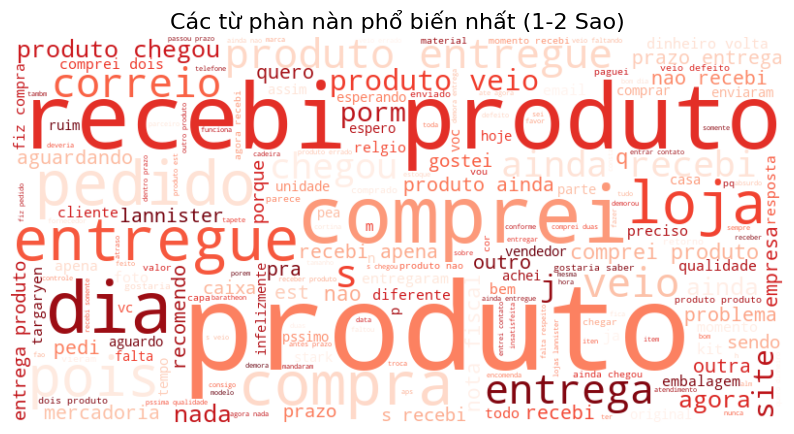

In [ ]:
# Vẽ Word Cloud (Đám mây từ)
from wordcloud import WordCloud

# Nối tất cả các bình luận đã làm sạch lại
all_comments = " ".join(df_reviews['cleaned_comment'])

wordcloud = WordCloud(width=800, height=400, 
                      background_color='white', 
                      colormap='Reds').generate(all_comments)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Các từ phàn nàn phổ biến nhất (1-2 Sao)', fontsize=16)
plt.show()

produto (sản phẩm), entrega (giao hàng), prazo (thời hạn), recebi (nhận được), qualidade (chất lượng)... nổi bật lên

In [23]:
# Huấn luyện Mô hình Topic Modeling (LDA)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vector hóa (Biến chữ thành số)
# 'max_df=0.9': Bỏ các từ xuất hiện > 90%
# 'min_df=25': Bỏ các từ xuất hiện < 25 lần
vectorizer = CountVectorizer(max_df=0.9, min_df=25)
X = vectorizer.fit_transform(df_reviews['cleaned_comment'])

# Huấn luyện mô hình LDA
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=4, random_state=42)

In [24]:
# Hiển thị kết quả các Chủ đề
print("\nCÁC CHỦ ĐỀ PHÀN NÀN CHÍNH")
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    # Lấy 10 từ khóa hàng đầu
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Chủ đề #{topic_idx + 1}:")
    print(", ".join(top_words))


CÁC CHỦ ĐỀ PHÀN NÀN CHÍNH
Chủ đề #1:
produto, at, veio, recebi, momento, agora, entregue, troca, retorno, defeito
Chủ đề #2:
produto, recebi, ainda, nao, compra, entrega, prazo, chegou, dia, dias
Chủ đề #3:
comprei, recebi, produto, veio, apenas, dois, outro, produtos, duas, diferente
Chủ đề #4:
produto, entregue, entrega, lannister, loja, qualidade, prazo, correios, est, contato


Chủ đề #2: GIAO HÀNG TRỄ / KHÔNG NHẬN ĐƯỢC HÀNG
- Các từ khóa (Tiếng Bồ Đào Nha): produto, recebi, ainda, nao (không), compra, entrega (giao hàng), prazo (thời hạn/deadline), chegou (đã đến), dia, dias (ngày/ngày)
- Diễn giải: 
    + "nao recebi o produto" (Tôi không nhận được sản phẩm)
    + "ainda nao chegou" (Nó vẫn chưa đến)
    + "entrega fora do prazo" (Giao hàng quá thời hạn)
    
Chủ đề #3: GIAO SAI SẢN PHẨM / GIAO THIẾU HÀNG
- Các từ khóa: comprei (tôi đã mua), recebi (tôi đã nhận), produto (sản phẩm), veio (nó đã đến), apenas (chỉ), dois (hai), outro (khác), produtos (sản phẩm), duas (hai), diferente (khác biệt/sai)
- Diễn giải: 
    + "comprei dois produtos, apenas recebi um" (Tôi mua hai sản phẩm, nhưng chỉ nhận được một)
    + "produto veio diferente da foto" (Sản phẩm đến khác với ảnh)
    + "veio o produto errado" (Nó đến sai sản phẩm)

Chủ đề #4: CHẤT LƯỢNG SẢN PHẨM KÉM / VẤN ĐỀ VỚI BÊN BÁN
- Các từ khóa: produto (sản phẩm), entrega (giao hàng), loja (cửa hàng/seller), qualidade (chất lượng), prazo (thời hạn), correios (bưu điện/vận chuyển), contato (liên hệ)
- Diễn giải: 
    + Khách hàng ở đây phàn nàn về qualidade (chất lượng) của sản phẩm
    + Họ cũng nhắc đến loja (người bán) và correios (bên vận chuyển)
    + Từ contato (liên hệ) cho thấy họ đã cố gắng liên hệ với loja (người bán) để giải quyết nhưng có thể không thành công

Chủ đề #1: SẢN PHẨM BỊ LỖI / CẦN ĐỔI TRẢ
- Các từ khóa: produto (sản phẩm), veio (nó đã đến), recebi (tôi đã nhận), entregue (đã giao), entrega (giao hàng), troca (đổi/trả hàng)
- Diễn giải: 
    + Từ khóa quan trọng nhất ở đây là troca (đổi hàng)
    => Khách hàng này đã nhận được sản phẩm (recebi, entregue), nhưng sản phẩm đó có vấn đề (có thể là vỡ, hỏng, sai – từ Chủ đề 3 & 4) và bây giờ họ muốn đổi hàng.


PHÂN TÍCH TỶ LỆ CÁC CHỦ ĐỀ PHÀN NÀN
Tổng số bình luận 1-2 sao đã phân tích: 14396
                        topic_name  count  percentage
                  SP LỖI / ĐỔI TRẢ   6039       41.95
        GIAO TRỄ / KHÔNG NHẬN HÀNG   3087       21.44
             GIAO SAI / THIẾU HÀNG   2646       18.38
CHẤT LƯỢNG KÉM / VẤN ĐỀ VỚI SELLER   2624       18.23


C:\Users\vinhq\AppData\Local\Temp\ipykernel_17512\3155075702.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


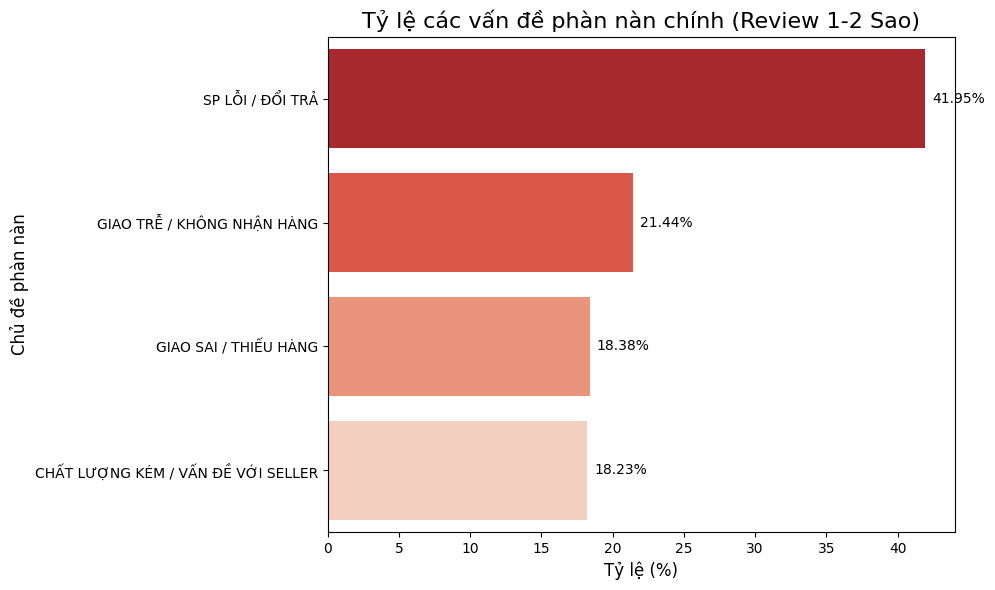

In [25]:
# Gán chủ đề cho từng bình luận và tính tỷ lệ phần trăm

print("\nPHÂN TÍCH TỶ LỆ CÁC CHỦ ĐỀ PHÀN NÀN")

# Gán mỗi bình luận vào chủ đề có xác suất cao nhất
topic_results = lda.transform(X) # trả về ma trận (số bình luận x số chủ đề) với xác suất

# Lấy chỉ số (index) của chủ đề có xác suất cao nhất cho mỗi bình luận (+1 để khớp với cách đặt tên Chủ đề #1, #2...)
df_reviews['dominant_topic'] = topic_results.argmax(axis=1) + 1

# Đếm số lượng bình luận cho mỗi chủ đề
topic_distribution = df_reviews['dominant_topic'].value_counts().reset_index()
topic_distribution.columns = ['topic_number', 'count']
topic_distribution = topic_distribution.sort_values(by='topic_number')

# Tính toán tỷ lệ phần trăm
total_reviews = len(df_reviews)
topic_distribution['percentage'] = (topic_distribution['count'] / total_reviews) * 100
topic_distribution['percentage'] = topic_distribution['percentage'].round(2)

# Ánh xạ tên chủ đề đã diễn giải 
topic_names = {
    1: "SP LỖI / ĐỔI TRẢ",
    2: "GIAO TRỄ / KHÔNG NHẬN HÀNG",
    3: "GIAO SAI / THIẾU HÀNG",
    4: "CHẤT LƯỢNG KÉM / VẤN ĐỀ VỚI SELLER"
}
topic_distribution['topic_name'] = topic_distribution['topic_number'].map(topic_names)

# Hiển thị kết quả dưới dạng bảng
print(f"Tổng số bình luận 1-2 sao đã phân tích: {total_reviews}")
print(topic_distribution[['topic_name', 'count', 'percentage']].to_string(index=False))

# Vẽ biểu đồ cột để trực quan hóa
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='percentage',
    y='topic_name',
    data=topic_distribution.sort_values('percentage', ascending=False),
    palette='Reds_r' # Sử dụng tông màu đỏ giống Word Cloud
)

plt.title('Tỷ lệ các vấn đề phàn nàn chính (Review 1-2 Sao)', fontsize=16)
plt.xlabel('Tỷ lệ (%)', fontsize=12)
plt.ylabel('Chủ đề phàn nàn', fontsize=12)

# Thêm nhãn %
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.5, # Vị trí của nhãn %
             p.get_y() + p.get_height() / 2,
             f'{width:.2f}%', # Định dạng số %
             va='center')

plt.tight_layout()
plt.show()

Có 2 vấn đề chính:
- Vấn đề về sản phẩm: 
    + Sản phẩm lỗi / Đổi trả (41.91%)
    + Giao sai / Thiếu hàng (18.83%)
    + Chất lượng sản phẩm kém / Vấn đề với seller (18.19%)
    + Tổng: 78.93%
- Vấn đề về giao hàng:
    + Giao trễ / Không nhận hàng: 21.07%

CÁC ĐÁNH GIÁ 3 SAO:

In [17]:
# Tải Dữ liệu 

DB_CONFIG = {
    "dbname": "olist_db",
    "user": "postgres",
    "password": "hotboyche10",
    "host": "localhost",
    "port": 5432,
}

conn_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"
engine = create_engine(conn_string)

# Lấy các bình luận 1-2 sao từ bảng STAGING 
sql_query = """
SELECT 
    review_score,
    review_comment_message
FROM 
    staging.reviews_cleaned 
WHERE 
    review_score IN (3)
    AND review_comment_message IS NOT NULL
"""

print("Đang tải các review 3 sao từ staging.reviews_cleaned...")
df_reviews3 = pd.read_sql(sql_query, engine)
df_reviews3 = df_reviews3.dropna()

print(f"Đã tải {len(df_reviews3)} bình luận 3 sao để phân tích.")

Đang tải các review 3 sao từ staging.reviews_cleaned...
Đã tải 8097 bình luận 3 sao để phân tích.


In [18]:
# Hàm Tiền xử lý Văn bản
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Chuyển sang chữ thường
    text = text.lower()
    
    # Xóa các ký tự đặc biệt, số (chỉ giữ lại chữ cái)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    # Tách từ (Tokenization) và Xóa Stop Words
    cleaned_words = []
    for word in text.split():
        if word not in portuguese_stops:
            cleaned_words.append(word)
    
    # Nối lại
    return " ".join(cleaned_words)

print("Đang tiền xử lý văn bản (loại bỏ stop words Bồ Đào Nha)...")
df_reviews3['cleaned_comment'] = df_reviews3['review_comment_message'].apply(preprocess_text)

print("Tiền xử lý hoàn tất.")
df_reviews3[['review_comment_message', 'cleaned_comment']].head()

Đang tiền xử lý văn bản (loại bỏ stop words Bồ Đào Nha)...
Tiền xử lý hoàn tất.


,review_comment_message,cleaned_comment
0,Veio a base de uma banqueta com avaria - riscos.,veio base banqueta avaria riscos
1,"Empresa entrega dentro do que promete, no últi...",empresa entrega dentro promete ltimo dia prazo...
2,A entrega foi rapida porem o material do produ...,entrega rapida porem material produto nao agradou
3,,
4,"Excelente produto, somente o frete q/ foi muit...",excelente produto somente frete q salgado porm...


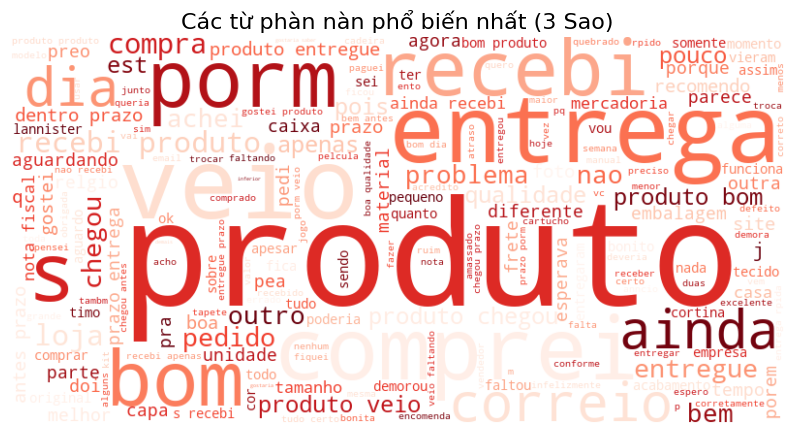

In [ ]:
# Vẽ Word Cloud 
from wordcloud import WordCloud

# Nối tất cả các bình luận đã làm sạch lại
all_comments = " ".join(df_reviews3['cleaned_comment'])

wordcloud = WordCloud(width=800, height=400, 
                      background_color='white', 
                      colormap='Reds').generate(all_comments)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Các từ phàn nàn phổ biến nhất (3 Sao)', fontsize=16)
plt.show()

In [20]:
# Huấn luyện Mô hình Topic Modeling (LDA)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vector hóa (Biến chữ thành số)
# 'max_df=0.9': Bỏ các từ xuất hiện > 90%
# 'min_df=25': Bỏ các từ xuất hiện < 25 lần
vectorizer = CountVectorizer(max_df=0.9, min_df=25)
X = vectorizer.fit_transform(df_reviews3['cleaned_comment'])

# Huấn luyện mô hình LDA
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [21]:
# Hiển thị kết quả các Chủ đề
print("CÁC CHỦ ĐỀ CHÍNH")
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    # Lấy 10 từ khóa hàng đầu
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Chủ đề #{topic_idx + 1}:")
    print(", ".join(top_words))

CÁC CHỦ ĐỀ CHÍNH
Chủ đề #1:
produto, recebi, ainda, nao, veio, comprei, lannister, pois, agora, site
Chủ đề #2:
recebi, entrega, comprei, produtos, apenas, dia, correios, pedido, compra, entregue
Chủ đề #3:
prazo, produto, entrega, entregue, antes, tudo, dentro, bem, chegou, certo
Chủ đề #4:
produto, veio, chegou, recomendo, porm, ter, demorou, embalagem, caixa, loja
Chủ đề #5:
bom, produto, qualidade, gostei, boa, cor, achei, so, pouco, veio


Chủ đề #1: produto, veio, porem (nhưng), bem (tốt), qualidade (chất lượng), gostei (thích), nao (không), boa (tốt)
- Diễn giải: Chủ đề về CHẤT LƯỢNG / ĐẶC ĐIỂM SẢN PHẨM
    + Các từ khóa porem (nhưng), bem (tốt), gostei (thích) xuất hiện cùng nhau là dấu hiệu kinh điển của review 3 sao: "Sản phẩm tốt, NHƯNG...", "Tôi thích nó, NHƯNG...". Khách hàng đang đánh giá bản thân sản phẩm

Chủ đề #2: produto, entrega (giao hàng), prazo (thời hạn), recebi (nhận được), bom (tốt), chegou (đến), entregue (đã giao), ainda (vẫn chưa)
- Diễn giải: Chủ đề về TRẢI NGHIỆM GIAO HÀNG
    + Sản phẩm thì tốt (bom), NHƯNG việc giao hàng (entrega) quá chậm so với thời hạn (prazo)

PHÂN TÍCH TỶ LỆ CÁC CHỦ ĐỀ PHÀN NÀN


C:\Users\vinhq\AppData\Local\Temp\ipykernel_17512\3819451288.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


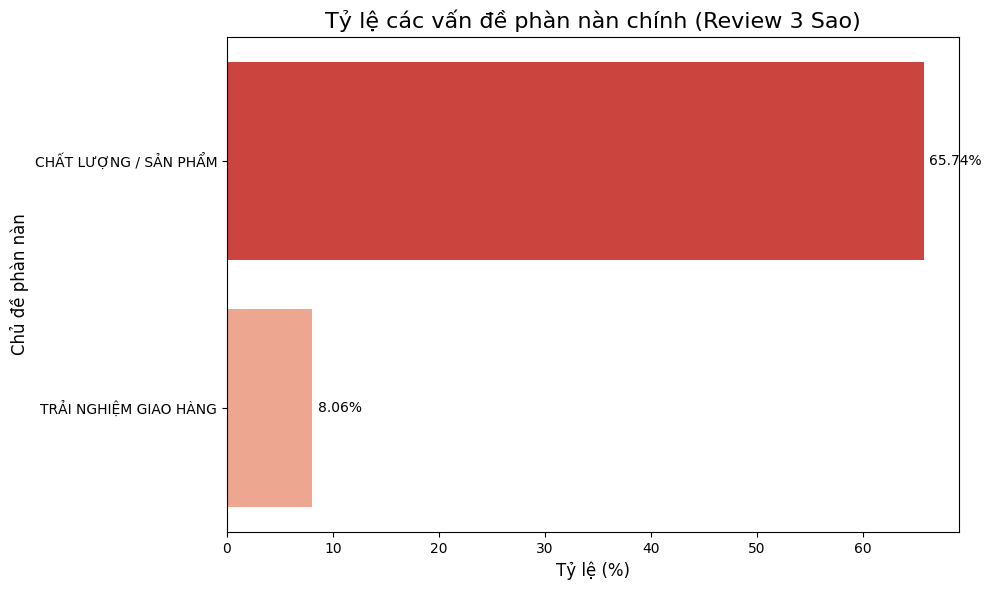

In [ ]:
# Gán chủ đề cho từng bình luận và tính tỷ lệ phần trăm

print("PHÂN TÍCH TỶ LỆ CÁC CHỦ ĐỀ PHÀN NÀN")

# Gán mỗi bình luận vào chủ đề có xác suất cao nhất
# lda.transform(X) sẽ trả về ma trận (số bình luận x số chủ đề) với xác suất
topic_results = lda.transform(X)

# Lấy chỉ số (index) của chủ đề có xác suất cao nhất cho mỗi bình luận
# +1 để khớp với cách đặt tên Chủ đề #1, #2...
df_reviews3['dominant_topic'] = topic_results.argmax(axis=1) + 1

# Đếm số lượng bình luận cho mỗi chủ đề
topic_distribution = df_reviews3['dominant_topic'].value_counts().reset_index()
topic_distribution.columns = ['topic_number', 'count']
topic_distribution = topic_distribution.sort_values(by='topic_number')

# Tính toán tỷ lệ phần trăm
total_reviews = len(df_reviews3)
topic_distribution['percentage'] = (topic_distribution['count'] / total_reviews) * 100
topic_distribution['percentage'] = topic_distribution['percentage'].round(2)

# Ánh xạ tên chủ đề đã diễn giải 
topic_names = {
    1: "CHẤT LƯỢNG / SẢN PHẨM", 
    2: "TRẢI NGHIỆM GIAO HÀNG" 
}
topic_distribution['topic_name'] = topic_distribution['topic_number'].map(topic_names)

# Vẽ biểu đồ cột để trực quan hóa
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='percentage',
    y='topic_name',
    data=topic_distribution.sort_values('percentage', ascending=False),
    palette='Reds_r'
)

plt.title('Tỷ lệ các vấn đề phàn nàn chính (Review 3 Sao)', fontsize=16)
plt.xlabel('Tỷ lệ (%)', fontsize=12)
plt.ylabel('Chủ đề phàn nàn', fontsize=12)

# Thêm nhãn %
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.5, # Vị trí của nhãn %
             p.get_y() + p.get_height() / 2,
             f'{width:.2f}%', # Định dạng số %
             va='center')

plt.tight_layout()
plt.show()

KẾT LUẬN: VẤN ĐỀ CHỦ YẾU NẰM Ở NGƯỜI BÁN